# comparison between autoencoders and traditional dimensionality reduction methods

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

### CIFAR-10 Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# normalizing image data (min-max normalization)
X_train_normalized = X_train / 255
X_test_normalized = X_test / 255

## declaring the batch size for global use
batch_size = 128

# reshaping the dataset for ease of use in the following sections
X_train_reshaped = X_train_normalized.reshape((X_train.shape[0], -1))
X_test_reshaped = X_test_normalized.reshape((X_test.shape[0], -1))
y_train_reshaped = y_train.flatten()
y_test_reshaped = y_test.flatten()

In [ ]:
print('train data:', X_train.shape)
print('test data:', X_test.shape)

train data: (50000, 32, 32, 3)
test data: (10000, 32, 32, 3)


### K Nearest Neighbors (KNN) Classifier

We will use KNN classifier along the notebook to examine the performance of each method.

In [ ]:
def KNN_train_and_eval(n_neighbors, X_train, X_test, y_train, y_test):

    clf = KNN(n_neighbors=n_neighbors).fit(X_train, y_train)
    yp = clf.predict(X_test)
    return accuracy_score(y_test, yp) * 100

## PCA Method (Principal Component Analysis)

In [ ]:
def plot_main_components(X):

    pca = PCA(n_components=10).fit(X)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5), dpi=80)
    axes = axes.ravel()

    for i in range(10):
        component = pca.components_[i].reshape((32,32,3)).mean(axis=2)
        axes[i].imshow(component, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'component {i}')

    plt.tight_layout()
    plt.show()

First, let's see the main components of the cifar10 dataset. (To display them easier I've converted the components to grayscale, because the range of the numbers are different for each components and each color and thus we need a colormap to see the components)

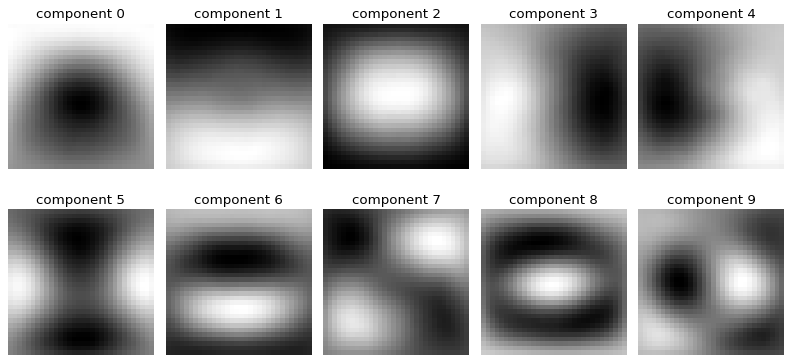

In [ ]:
plot_main_components(X_train_reshaped)

In [ ]:
def random_search_parameter_space(Decompositor, nc, nn_per_nc,
        X_train, X_test, y_train, y_test):

    for n_components in np.sort(np.random.randint(1, 100, nc)):
        decompositor = Decompositor(n_components=n_components)
        decompositor.fit(X_train)

        latent_train = decompositor.transform(X_train)
        latent_test = decompositor.transform(X_test)

        for n_neighbors in np.sort(np.random.randint(1, 100, nn_per_nc)):
            accuracy = KNN_train_and_eval(n_neighbors, latent_train, latent_test, y_train, y_test)
            print(f'n_components={n_components}, ', end='')
            print(f'n_neighbors={n_neighbors:2} ', end='')
            print(f'=> accuracy={accuracy:.2f}', end='\n')

This is a very similar algorithm to random search. However, because of the the time-consuming nature of computing the decomposition mapping using methods like PCA or Isomap, I've implemented the ability to explore multiple values for the number of neighbors (k) in the KNN classifier and evaluate the corresponding results. If nn_per_nc is set to 1, the function behaves exactly like a random search, where nc determines the total number of attempts.

In [ ]:
random_search_parameter_space(PCA, 4, 3,
    X_train_reshaped, X_test_reshaped, y_train_reshaped, y_test_reshaped)

n_components=19, n_neighbors= 8 => accuracy=40.35
n_components=19, n_neighbors=31 => accuracy=41.50
n_components=19, n_neighbors=96 => accuracy=40.30
n_components=45, n_neighbors=42 => accuracy=39.46
n_components=45, n_neighbors=74 => accuracy=38.87
n_components=45, n_neighbors=97 => accuracy=38.44
n_components=75, n_neighbors=11 => accuracy=39.71
n_components=75, n_neighbors=30 => accuracy=38.51
n_components=75, n_neighbors=60 => accuracy=37.32
n_components=91, n_neighbors=22 => accuracy=38.51
n_components=91, n_neighbors=36 => accuracy=37.70
n_components=91, n_neighbors=58 => accuracy=36.84


## Ispmap Method

This methods needs a lot of computation. The time complexity of this method is approximately $o(n^2 \log{n})$ and that's why I will only use 10% of the dataset for it.

In [ ]:
random_search_parameter_space(Isomap, 3, 4,
    X_train_reshaped[:5000], X_test_reshaped[:1000],
    y_train_reshaped[:5000], y_test_reshaped[:1000])

n_components=9, n_neighbors= 1 => accuracy=18.50
n_components=9, n_neighbors=13 => accuracy=25.20
n_components=9, n_neighbors=69 => accuracy=25.30
n_components=9, n_neighbors=99 => accuracy=26.50
n_components=23, n_neighbors=36 => accuracy=26.30
n_components=23, n_neighbors=51 => accuracy=27.10
n_components=23, n_neighbors=85 => accuracy=27.10
n_components=23, n_neighbors=89 => accuracy=26.60
n_components=27, n_neighbors=45 => accuracy=27.10
n_components=27, n_neighbors=89 => accuracy=25.90
n_components=27, n_neighbors=93 => accuracy=25.60
n_components=27, n_neighbors=95 => accuracy=26.30


## Autoencoder

 As a regularization method, Dropout layers are used in the autoencoder with Dense layers and Batch-Normalization layers are used in the autoencoder with convolutional layers.

In [ ]:
def build_dense_auto_encoder(latent_dim):

    encoder_input = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Flatten()(encoder_input)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(latent_dim)(x)
    x = tf.keras.layers.LeakyReLU(0.1)(x)

    encoder = tf.keras.models.Model(inputs=encoder_input, outputs=x)

    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(512)(decoder_input)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32*32*3)(x)
    x = tf.keras.layers.ReLU(max_value=1.0)(x)
    x = tf.keras.layers.Reshape((32, 32, 3))(x)

    decoder = tf.keras.models.Model(inputs=decoder_input, outputs=x)

    auto_encoder = tf.keras.models.Model(
        inputs=encoder.input, outputs=decoder(encoder.output))

    return encoder, decoder, auto_encoder

In [ ]:
def build_convolutional_auto_encoder(latent_dim):

    encoder_input = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(encoder_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(latent_dim)(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)

    encoder = tf.keras.models.Model(inputs=encoder_input, outputs=x)

    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(4*4*64)(decoder_input)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Reshape((4, 4, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)

    decoder = tf.keras.models.Model(inputs=decoder_input, outputs=x)

    auto_encoder = tf.keras.models.Model(
        inputs=encoder.input, outputs=decoder(encoder.output))

    return encoder, decoder, auto_encoder

I've used MSE loss to train the autoencoders, but it's also possible to use MAE loss. In this case that we are more interested in integrity of the latent space rather than quality of the output, it's better to use MSE loss function based on my experience.

In [ ]:
def compile_and_train_auto_encoder(auto_encoder):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
        0.001, decay_steps=X_train.shape[0]//batch_size,
        decay_rate=0.85, staircase=True
    )

    adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    auto_encoder.compile(optimizer=adam, loss='mse')

    history = auto_encoder.fit (
        x=X_train_normalized,
        y=X_train_normalized,
        batch_size=batch_size,
        epochs=10
    )

    return history

In [ ]:
def evaluate_encoder(encoder):

    latent_train = encoder.predict(X_train_normalized, verbose=0)
    latent_test = encoder.predict(X_test_normalized, verbose=0)

    for n in [5, 10, 15, 25, 35, 50]:
        accuracy = KNN_train_and_eval(n, latent_train, latent_test, y_train_reshaped, y_test_reshaped)
        print(f'latent_dim={latent_train.shape[1]}, n_neighbors={n:2} => accuracy={accuracy:.2f}')

In [ ]:
encoder, decoder, auto_encoder = build_dense_auto_encoder(40)
history = compile_and_train_auto_encoder(auto_encoder)

Epoch 1/10
391/391 [==============================] - 7s 6ms/step - loss: 0.0358
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0241
Epoch 3/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0224
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0217
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0208
Epoch 6/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0203
Epoch 7/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0198
Epoch 8/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0194
Epoch 9/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0191
Epoch 10/10
391/391 [==============================] - 3s 6ms/step - loss: 0.0188


In [ ]:
evaluate_encoder(encoder)

latent_dim=40, n_neighbors= 5 => accuracy=39.09
latent_dim=40, n_neighbors=10 => accuracy=41.44
latent_dim=40, n_neighbors=15 => accuracy=41.93
latent_dim=40, n_neighbors=25 => accuracy=42.31
latent_dim=40, n_neighbors=35 => accuracy=42.27
latent_dim=40, n_neighbors=50 => accuracy=42.17


In [ ]:
encoder, decoder, auto_encoder = build_dense_auto_encoder(80)
history = compile_and_train_auto_encoder(auto_encoder)

Epoch 1/10
391/391 [==============================] - 7s 7ms/step - loss: 0.0355
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0238
Epoch 3/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0213
Epoch 4/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0200
Epoch 5/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0193
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 0.0187
Epoch 7/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0183
Epoch 8/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0179
Epoch 9/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0176
Epoch 10/10
391/391 [==============================] - 2s 6ms/step - loss: 0.0175


In [ ]:
evaluate_encoder(encoder)

latent_dim=80, n_neighbors= 5 => accuracy=42.04
latent_dim=80, n_neighbors=10 => accuracy=43.89
latent_dim=80, n_neighbors=15 => accuracy=44.64
latent_dim=80, n_neighbors=25 => accuracy=44.91
latent_dim=80, n_neighbors=35 => accuracy=44.66
latent_dim=80, n_neighbors=50 => accuracy=44.31


In [ ]:
encoder, decoder, auto_encoder = build_convolutional_auto_encoder(30)
history = compile_and_train_auto_encoder(auto_encoder)

Epoch 1/10
391/391 [==============================] - 17s 12ms/step - loss: 0.0260
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0182
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0161
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0155
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0151
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0147
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.0145
Epoch 8/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0143
Epoch 9/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0142
Epoch 10/10
391/391 [==============================] - 4s 10ms/step - loss: 0.0140


In [ ]:
evaluate_encoder(encoder)

latent_dim=30, n_neighbors= 5 => accuracy=39.14
latent_dim=30, n_neighbors=10 => accuracy=40.62
latent_dim=30, n_neighbors=15 => accuracy=40.73
latent_dim=30, n_neighbors=25 => accuracy=40.84
latent_dim=30, n_neighbors=35 => accuracy=40.69
latent_dim=30, n_neighbors=50 => accuracy=40.28


In [ ]:
encoder, decoder, auto_encoder = build_convolutional_auto_encoder(90)
history = compile_and_train_auto_encoder(auto_encoder)

Epoch 1/10
391/391 [==============================] - 9s 11ms/step - loss: 0.0214
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0131
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0119
Epoch 4/10
391/391 [==============================] - 5s 13ms/step - loss: 0.0111
Epoch 5/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0106
Epoch 6/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0103
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.0100
Epoch 8/10
391/391 [==============================] - 4s 10ms/step - loss: 0.0098
Epoch 9/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0097
Epoch 10/10
391/391 [==============================] - 4s 9ms/step - loss: 0.0096


In [ ]:
evaluate_encoder(encoder)

latent_dim=90, n_neighbors= 5 => accuracy=41.53
latent_dim=90, n_neighbors=10 => accuracy=41.66
latent_dim=90, n_neighbors=15 => accuracy=42.02
latent_dim=90, n_neighbors=25 => accuracy=40.98
latent_dim=90, n_neighbors=35 => accuracy=40.74
latent_dim=90, n_neighbors=50 => accuracy=39.77


## VAE (Variational Autoencoder)

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [ ]:
def build_dense_vae(latent_dim):

    encoder_input = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Flatten()(encoder_input)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    # x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(latent_dim, activation='linear')(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_var')(x)

    encoder = tf.keras.models.Model(inputs=encoder_input, outputs=z_mean)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.keras.backend.exp(z_log_var * 0.5) * epsilon

    z = tf.keras.layers.Lambda(
        sampling, output_shape=(latent_dim,),
        name='sampling')([z_mean, z_log_var])

    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(256)(decoder_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    # x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1024)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    # x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(32*32*3)(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    decoded_mean = tf.keras.layers.Reshape((32, 32, 3))(x)

    decoder = tf.keras.models.Model(inputs=decoder_input, outputs=decoded_mean)

    def vae_loss(x, decoded_mean):
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(x, decoded_mean) * (32*32*3)
        kl_loss = -0.5 * tf.keras.backend.mean(
            1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var))

        return reconstruction_loss + kl_loss

    vae = tf.keras.models.Model(inputs=encoder_input, outputs=decoder(z))

    return encoder, decoder, vae, vae_loss

In [ ]:
def build_convolutional_vae(latent_dim):

    encoder_input = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(encoder_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name='z_var')(x)

    encoder = tf.keras.models.Model(inputs=encoder_input, outputs=z_mean)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = tf.keras.backend.random_normal(shape=(tf.shape(z_mean)[0], latent_dim))
        return z_mean + tf.keras.backend.exp(z_log_var * 0.5) * epsilon

    z = tf.keras.layers.Lambda(
        sampling, output_shape=(latent_dim,),
        name='sampling')([z_mean, z_log_var])

    decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(4*4*64)(decoder_input)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Reshape((4, 4, 64))(x)
    x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.05)(x)
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x)
    decoded_mean = tf.keras.layers.Activation('sigmoid')(x)

    decoder = tf.keras.models.Model(inputs=decoder_input, outputs=decoded_mean)

    def vae_loss(x, decoded_mean):
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(x, decoded_mean) * (32*32*3)
        kl_loss = -0.5 * tf.keras.backend.mean(
            1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var))

        return reconstruction_loss + kl_loss

    vae = tf.keras.models.Model(inputs=encoder_input, outputs=decoder(z))

    return encoder, decoder, vae, vae_loss

In [ ]:
def compile_and_train_vae(vae, vae_loss, epochs=10):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay (
        0.001, decay_steps=X_train.shape[0]//batch_size,
        decay_rate=0.85, staircase=True
    )

    adam = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)
    vae.compile(optimizer=adam, loss=vae_loss)

    history = vae.fit (
        x=X_train_normalized,
        y=X_train_normalized,
        batch_size=batch_size,
        epochs=epochs
    )

    return history

In [ ]:
def plot_latent_distribution(encoder):
    latent = encoder.predict(X_train_normalized, verbose=0)
    plt.hist(latent.flatten(), bins=np.arange(-5, 6), density=True, label='latent space')
    normal_dist = np.exp(-np.arange(-5, 6, 0.1)**2 / 2) / np.sqrt(np.pi*2)
    plt.plot(np.arange(-5, 6, 0.1), normal_dist, label='std normal')
    plt.title('latent space distribution')
    plt.legend()
    plt.show()

In [ ]:
encoder, decoder, vae, vae_loss = build_dense_vae(40)
history = compile_and_train_vae(vae, vae_loss)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 11s 229us/sample - loss: 94.0613
Epoch 2/10
50000/50000 [==============================] - 6s 118us/sample - loss: 67.8539
Epoch 3/10
50000/50000 [==============================] - 5s 107us/sample - loss: 60.5367
Epoch 4/10
50000/50000 [==============================] - 6s 115us/sample - loss: 57.1627
Epoch 5/10
50000/50000 [==============================] - 6s 112us/sample - loss: 54.8519
Epoch 6/10
50000/50000 [==============================] - 6s 124us/sample - loss: 53.0345
Epoch 7/10
50000/50000 [==============================] - 6s 117us/sample - loss: 51.7322
Epoch 8/10
50000/50000 [==============================] - 5s 106us/sample - loss: 50.7403
Epoch 9/10
50000/50000 [==============================] - 6s 121us/sample - loss: 49.7972
Epoch 10/10
50000/50000 [==============================] - 5s 108us/sample - loss: 49.0158


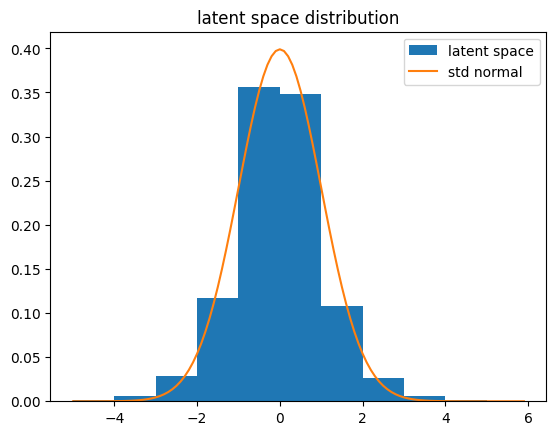

In [ ]:
plot_latent_distribution(encoder)

In [ ]:
evaluate_encoder(encoder)

latent_dim=40, n_neighbors= 5 => accuracy=41.60
latent_dim=40, n_neighbors=10 => accuracy=43.03
latent_dim=40, n_neighbors=15 => accuracy=43.36
latent_dim=40, n_neighbors=25 => accuracy=43.61
latent_dim=40, n_neighbors=35 => accuracy=43.35
latent_dim=40, n_neighbors=50 => accuracy=42.92


In [ ]:
encoder, decoder, vae, vae_loss = build_dense_vae(70)
history = compile_and_train_vae(vae, vae_loss)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 164us/sample - loss: 97.3502
Epoch 2/10
50000/50000 [==============================] - 6s 123us/sample - loss: 69.7651
Epoch 3/10
50000/50000 [==============================] - 6s 111us/sample - loss: 62.5215
Epoch 4/10
50000/50000 [==============================] - 7s 135us/sample - loss: 59.1185
Epoch 5/10
50000/50000 [==============================] - 5s 110us/sample - loss: 56.4397
Epoch 6/10
50000/50000 [==============================] - 6s 121us/sample - loss: 54.4517
Epoch 7/10
50000/50000 [==============================] - 6s 112us/sample - loss: 52.7382
Epoch 8/10
50000/50000 [==============================] - 6s 120us/sample - loss: 51.1803
Epoch 9/10
50000/50000 [==============================] - 6s 113us/sample - loss: 49.9846
Epoch 10/10
50000/50000 [==============================] - 6s 117us/sample - loss: 49.1675


In [ ]:
evaluate_encoder(encoder)

latent_dim=70, n_neighbors= 5 => accuracy=41.15
latent_dim=70, n_neighbors=10 => accuracy=42.80
latent_dim=70, n_neighbors=15 => accuracy=42.43
latent_dim=70, n_neighbors=25 => accuracy=42.55
latent_dim=70, n_neighbors=35 => accuracy=42.40
latent_dim=70, n_neighbors=50 => accuracy=41.85


In [ ]:
encoder, decoder, vae, vae_loss = build_convolutional_vae(50)
history = compile_and_train_vae(vae, vae_loss)

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 14s 282us/sample - loss: 70.5219
Epoch 2/10
50000/50000 [==============================] - 9s 182us/sample - loss: 43.8267
Epoch 3/10
50000/50000 [==============================] - 9s 185us/sample - loss: 40.3438
Epoch 4/10
50000/50000 [==============================] - 9s 170us/sample - loss: 38.5058
Epoch 5/10
50000/50000 [==============================] - 10s 191us/sample - loss: 37.2840
Epoch 6/10
50000/50000 [==============================] - 9s 185us/sample - loss: 36.3714
Epoch 7/10
50000/50000 [==============================] - 11s 214us/sample - loss: 35.4557
Epoch 8/10
50000/50000 [==============================] - 8s 167us/sample - loss: 35.0276
Epoch 9/10
50000/50000 [==============================] - 9s 188us/sample - loss: 34.7267
Epoch 10/10
50000/50000 [==============================] - 11s 222us/sample - loss: 34.4834


In [ ]:
evaluate_encoder(encoder)

latent_dim=50, n_neighbors= 5 => accuracy=42.21
latent_dim=50, n_neighbors=10 => accuracy=43.04
latent_dim=50, n_neighbors=15 => accuracy=42.79
latent_dim=50, n_neighbors=25 => accuracy=41.95
latent_dim=50, n_neighbors=35 => accuracy=41.61
latent_dim=50, n_neighbors=50 => accuracy=40.56


In [ ]:
encoder, decoder, vae, vae_loss = build_convolutional_vae(90)
history = compile_and_train_vae(vae, vae_loss, 20)

Train on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 10s 206us/sample - loss: 67.4025
Epoch 2/20
50000/50000 [==============================] - 9s 182us/sample - loss: 40.1706
Epoch 3/20
50000/50000 [==============================] - 9s 188us/sample - loss: 36.1360
Epoch 4/20
50000/50000 [==============================] - 9s 190us/sample - loss: 33.7044
Epoch 5/20
50000/50000 [==============================] - 8s 167us/sample - loss: 31.8795
Epoch 6/20
50000/50000 [==============================] - 10s 192us/sample - loss: 30.7398
Epoch 7/20
50000/50000 [==============================] - 10s 198us/sample - loss: 29.9591
Epoch 8/20
50000/50000 [==============================] - 9s 188us/sample - loss: 29.2796
Epoch 9/20
50000/50000 [==============================] - 8s 168us/sample - loss: 28.7607
Epoch 10/20
50000/50000 [==============================] - 10s 200us/sample - loss: 28.3278
Epoch 11/20
50000/50000 [==============================] - 11s 221us/sam

In [ ]:
evaluate_encoder(encoder)

latent_dim=90, n_neighbors= 5 => accuracy=40.18
latent_dim=90, n_neighbors=10 => accuracy=40.69
latent_dim=90, n_neighbors=15 => accuracy=40.13
latent_dim=90, n_neighbors=25 => accuracy=38.75
latent_dim=90, n_neighbors=35 => accuracy=38.18
latent_dim=90, n_neighbors=50 => accuracy=37.36


## Generation

In [ ]:
sample_1 = encoder.predict(X_test_normalized[10:11])[0]
sample_2 = encoder.predict(X_test_normalized[13:14])[0]
sample_3 = encoder.predict(X_test_normalized[14:15])[0]
sample_4 = encoder.predict(X_test_normalized[15:16])[0]

def construct_grid():
    latent_grid = []

    for i in range(11):
        row = []
        for j in range(11):
            z =  (10-i) * (10-j) * sample_1
            z += (10-i) * j * sample_2
            z += i * (10-j) * sample_3
            z += i * j * sample_4
            z = z / 100
            row.append(z)

        latent_grid.append(row)

    return np.array(latent_grid)

In [ ]:
def plot_samples_in_grid(imgs):
    fig, axes = plt.subplots(11, 11, figsize=(7, 7), dpi=100)

    for i in range(11):
        for j in range(11):
            axes[i, j].imshow(imgs[i, j])
            axes[i, j].axis('off')
            axes[i, j].set_aspect('equal')

    fig.tight_layout(pad=0.5)
    plt.show()

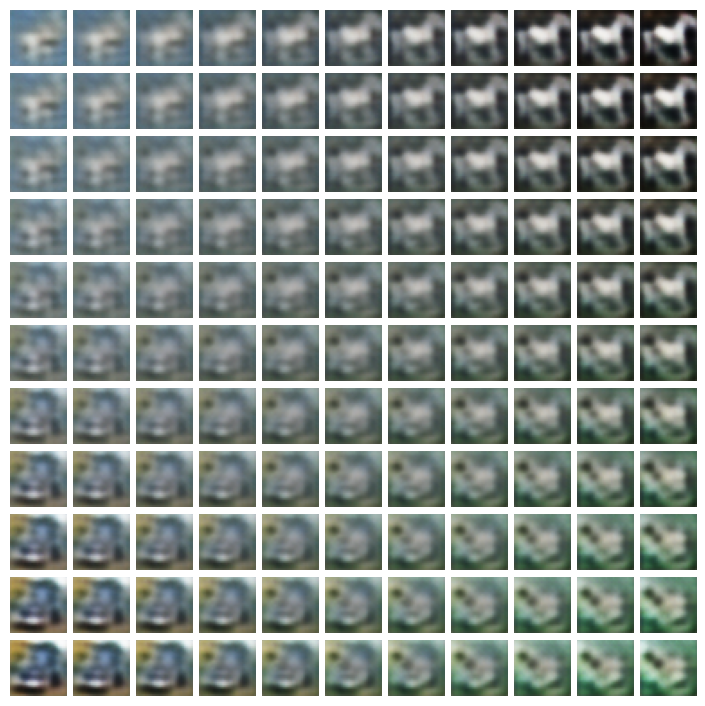

In [ ]:
latent_grid = construct_grid()
results = decoder.predict(latent_grid.reshape((121, 90)))
results = results.reshape((11, 11, 32, 32, 3)) * 255
results = results.astype(np.uint8)
plot_samples_in_grid(results)

In [ ]:
def plot_latent_scatter(encoder, dim_1, dim_2):
    latent = encoder.predict(X_train_normalized)
    for i in range(10):
        latent_cond = latent[y_train_reshaped==i]
        plt.scatter(latent_cond[:, dim_1], latent_cond[:, dim_2])

    plt.xlabel(f'z_{dim_1}')
    plt.ylabel(f'z_{dim_2}')
    plt.show()

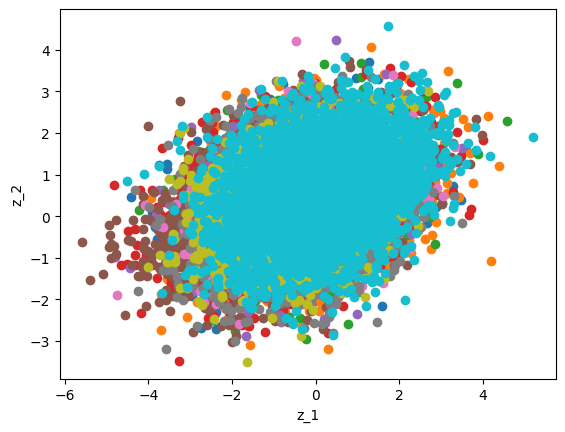

In [ ]:
plot_latent_scatter(encoder, 1, 2)